# Implementation of a KAN for classification

In [1]:
# Install all libraries you might neeed
%pip install pykan=="0.0.5" moviepy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import torch
from kan import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import moviepy.video.io.ImageSequenceClip

device="cpu"

## Loading the Dataset

The iris dataset is a well-known and widely used dataset in statistics and machine learning. It contains measurements of 150 iris flowers, with 50 samples each from three different species: Iris setosa, Iris virginica, and Iris versicolor.
For each sample, four features are measured:

Sepal length (in cm)
Sepal width (in cm)
Petal length (in cm)
Petal width (in cm)

This dataset is often used for classification tasks, where the goal is to predict the species of iris based on these four measurements. It's popular for teaching and testing machine learning algorithms due to its simplicity, small size, and the fact that one class (Iris setosa) is linearly separable from the other two.

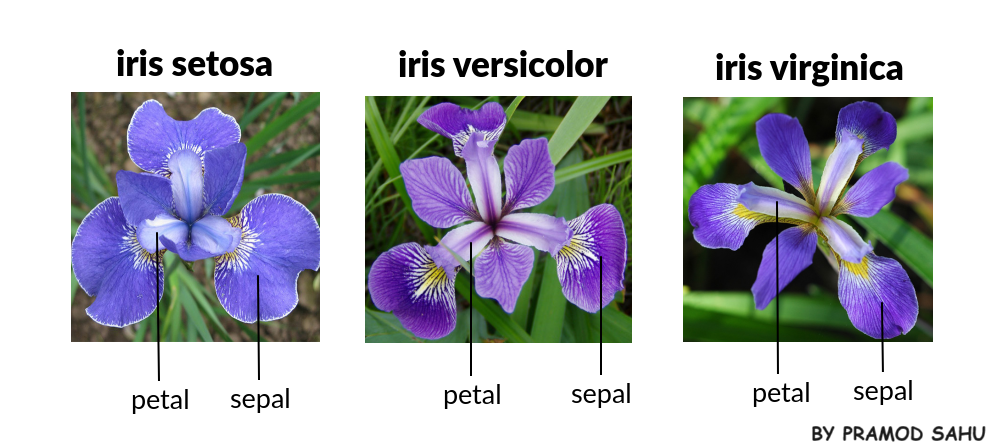

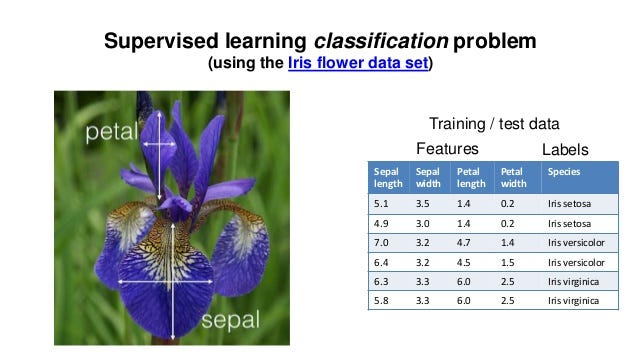

In [3]:
class IrisDataset:
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.data = self._prepare_data()

    def _prepare_data(self):
        iris = load_iris()
        X, y = iris.data, iris.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        data = {
            'train_input': torch.tensor(X_train, dtype=torch.float32).to(device),
            'test_input': torch.tensor(X_test, dtype=torch.float32).to(device),
            'train_label': torch.tensor(y_train, dtype=torch.long).to(device),
            'test_label': torch.tensor(y_test, dtype=torch.long).to(device)
        }
        return data

    def get_data(self):
        return self.data

    def print_shapes(self):
        for key, value in self.data.items():
            print(f"{key} shape: {value.shape}")
        print("=" * 40)

    def display_sample_data(self, num_samples=5):
        feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
        target_names = ['setosa', 'versicolor', 'virginica']

        df = pd.DataFrame(self.data['train_input'].cpu().numpy()[:num_samples], columns=feature_names)
        df['target'] = self.data['train_label'].cpu().numpy()[:num_samples]
        df['species'] = df['target'].map(lambda x: target_names[x])

        print(df.to_string(index=False))
        print("\nNote: These are the first five samples from the training set.")

In [4]:
# Create and use the IrisDataset class
iris_dataset = IrisDataset()
iris_data = iris_dataset.get_data()

In [5]:
print("Train data shape: {}".format(iris_data['train_input'].shape))
print("Train target shape: {}".format(iris_data['train_label'].shape))
print("Test data shape: {}".format(iris_data['test_input'].shape))
print("Test target shape: {}".format(iris_data['test_label'].shape))
print("====================================")

Train data shape: torch.Size([120, 4])
Train target shape: torch.Size([120])
Test data shape: torch.Size([30, 4])
Test target shape: torch.Size([30])


In [6]:
# Print dataset information
iris_dataset.print_shapes()

# Display the first five data points
iris_dataset.display_sample_data()

train_input shape: torch.Size([120, 4])
test_input shape: torch.Size([30, 4])
train_label shape: torch.Size([120])
test_label shape: torch.Size([30])
 sepal_length  sepal_width  petal_length  petal_width  target    species
          4.6          3.6           1.0          0.2       0     setosa
          5.7          4.4           1.5          0.4       0     setosa
          6.7          3.1           4.4          1.4       1 versicolor
          4.8          3.4           1.6          0.2       0     setosa
          4.4          3.2           1.3          0.2       0     setosa

Note: These are the first five samples from the training set.


## Creating and Training the KAN

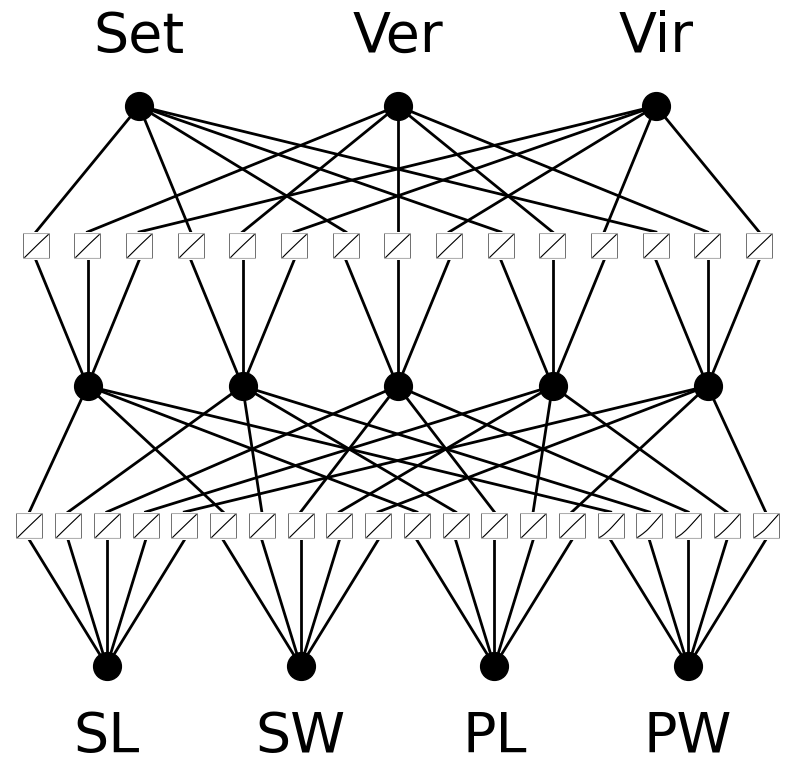

In [7]:
model = KAN(width=[4, 5, 3], grid=5, k=3, seed=0, device=device)

model(iris_data['train_input'])
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [8]:
def train_acc():
    return torch.mean((torch.argmax(model(iris_data['train_input']), dim=1) == iris_data['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(iris_data['test_input']), dim=1) == iris_data['test_label']).float())

results = model.train(iris_data, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=100, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder="video_img")

train loss: 1.92e-01 | test loss: 4.07e-01 | reg: 1.49e+02 : 100%|█| 100/100 [09:40<00:00,  5.80s/it


In [9]:
results['train_acc'][-1], results['test_acc'][-1]

(0.9833333492279053, 0.9666666388511658)

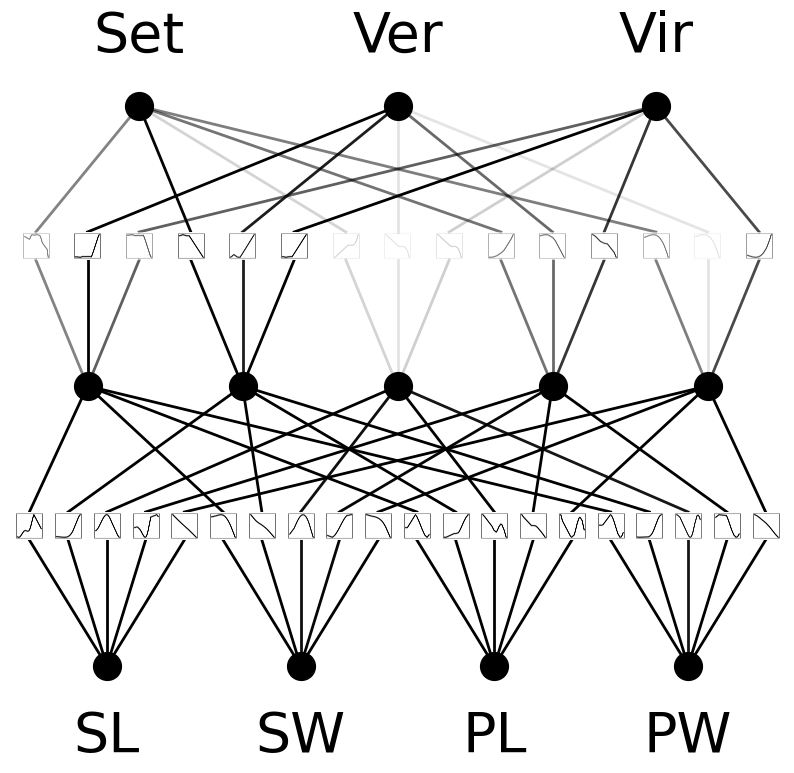

In [10]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [11]:
video_name='video'
fps=10

fps = fps
files = os.listdir("video_img")
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = ["video_img"+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


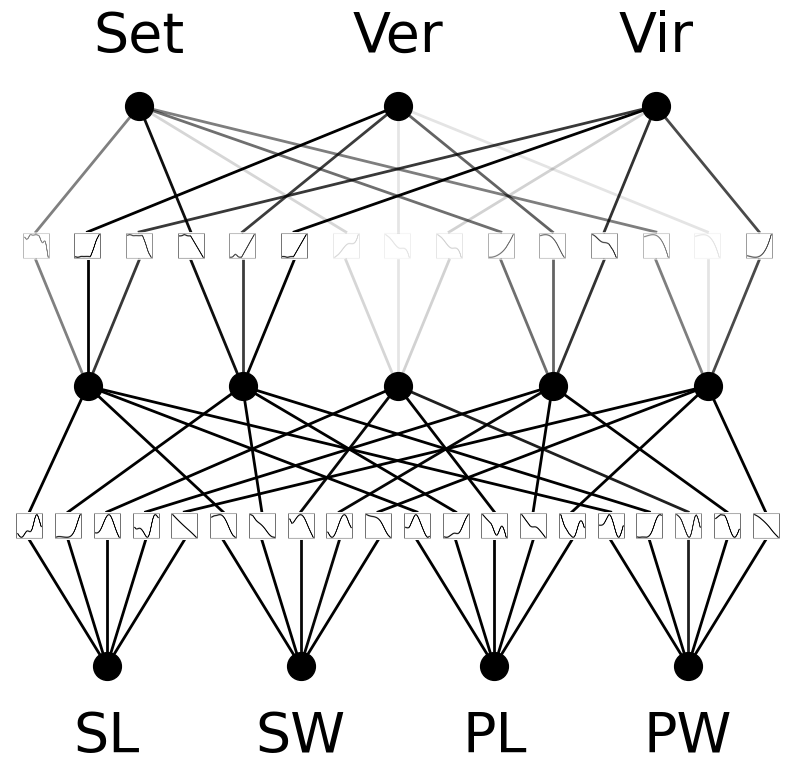

In [12]:
model = model.prune()
model(iris_data['train_input'])
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [13]:
# fine tune the model to reach 100% acc
results_1 = model.train(iris_data, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10.)
results_1['train_acc'][-1], results_1['test_acc'][-1]

train loss: 1.70e-01 | test loss: 1.11e-02 | reg: 1.70e+02 : 100%|██| 50/50 [00:04<00:00, 12.17it/s]


(1.0, 1.0)

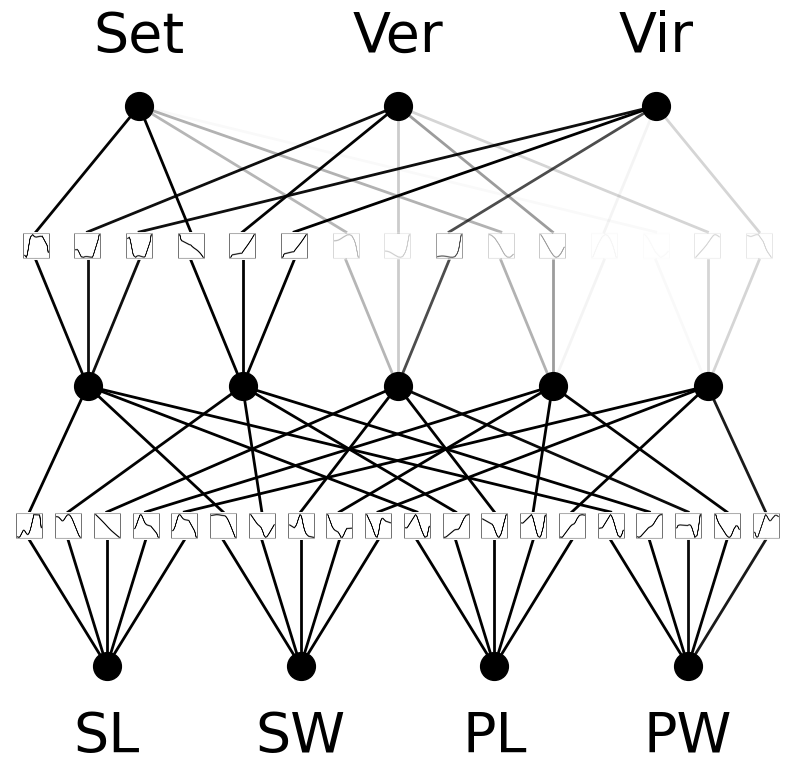

In [14]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

# Symbolic Formulas

To turn our model function's into symbolic ones, we must define a library of possible functions `lib` and run `auto_symbolic(lib=lib)`. Our KAN model will automatically assign each function in the lib to our splines based on similarity using R2-Score. This will probably make our model to be a bit less precise, as some of the functions may not be too similar to those defined in our lib.

In [15]:
lib = ['x','x^2','x^3','x^4','exp','sin']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.7051205635070801
fixing (0,0,1) with x^4, r2=0.8404161930084229
fixing (0,0,2) with sin, r2=0.9999566078186035
fixing (0,0,3) with sin, r2=0.8085970878601074
fixing (0,0,4) with x^4, r2=0.8736559748649597
fixing (0,1,0) with x^3, r2=0.9931091070175171
fixing (0,1,1) with sin, r2=0.9354825615882874
fixing (0,1,2) with sin, r2=0.8315492868423462
fixing (0,1,3) with x^2, r2=0.8663556575775146
fixing (0,1,4) with sin, r2=0.8639753460884094
fixing (0,2,0) with sin, r2=0.963004469871521
fixing (0,2,1) with sin, r2=0.9780039191246033
fixing (0,2,2) with sin, r2=0.9720076322555542
fixing (0,2,3) with sin, r2=0.9536215662956238
fixing (0,2,4) with sin, r2=0.9913135766983032
fixing (0,3,0) with sin, r2=0.9214867353439331
fixing (0,3,1) with sin, r2=0.9953842163085938
fixing (0,3,2) with sin, r2=0.7004278302192688
fixing (0,3,3) with x^2, r2=0.8763797879219055
fixing (0,3,4) with sin, r2=0.8941846489906311
fixing (1,0,0) with x^2, r2=0.90230393409729
fixing (1,0,1) w

In [16]:
# Obtain the global symbolic formula
model.symbolic_formula()

([4309.24*(1 - 0.18*x_1)**4 + 70405.06*(1 - 0.16*x_1)**8 - 264.89*(-(1 - 0.39*x_2)**3 - 0.17*sin(1.36*x_1 + 4.0) + 0.98*sin(1.14*x_3 - 5.21) + 0.79*sin(2.92*x_4 + 8.3) - 0.22)**2 - 0.11*exp(3.76*sin(0.43*x_1 + 0.61) + 1.64*sin(4.05*x_2 - 9.97) + 5.79*sin(1.21*x_3 - 7.66) - 0.14*sin(6.33*x_4 - 3.66)) - 79.05*sin(3.15*x_2 + 6.94) - 1753.19*sin(0.21*x_3 - 1.83) - 460.55*sin(0.99*x_4 + 4.81) - 1.79*sin(-3.73*(1 - 0.31*x_2)**2 - 1.01*(1 - 0.71*x_4)**2 + 0.89*sin(1.6*x_1 - 4.42) + 1.84*sin(1.22*x_3 - 5.08) + 9.36) - 1464.68,
  -101876.9*(1 - 0.16*x_1)**8 - 8749.53*((1 - 0.18*x_1)**4 - 0.02*sin(3.15*x_2 + 6.94) - 0.41*sin(0.21*x_3 - 1.83) - 0.11*sin(0.99*x_4 + 4.81) - 0.63)**3 + 80.93*(-(1 - 0.39*x_2)**3 - 0.17*sin(1.36*x_1 + 4.0) + 0.98*sin(1.14*x_3 - 5.21) + 0.79*sin(2.92*x_4 + 8.3) - 0.5)**4 + 32.36*(-(1 - 0.31*x_2)**2 - 0.27*(1 - 0.71*x_4)**2 + 0.24*sin(1.6*x_1 - 4.42) + 0.49*sin(1.22*x_3 - 5.08) + 0.21)**2 + 0.02*exp(4.7*sin(0.43*x_1 + 0.61) + 2.05*sin(4.05*x_2 - 9.97) + 7.22*sin(1.21*x_

Now that we have the symbolic formula that fits our data, let's use it for inference!

In [26]:
def iris_formula(x):
    x_1, x_2, x_3, x_4 = x

    f1 = (4309.24*(1 - 0.18*x_1)**4 + 70405.06*(1 - 0.16*x_1)**8 
          - 264.89*(-(1 - 0.39*x_2)**3 - 0.17*np.sin(1.36*x_1 + 4.0) + 0.98*np.sin(1.14*x_3 - 5.21) + 0.79*np.sin(2.92*x_4 + 8.3) - 0.22)**2 
          - 0.11*np.exp(3.76*np.sin(0.43*x_1 + 0.61) + 1.64*np.sin(4.05*x_2 - 9.97) + 5.79*np.sin(1.21*x_3 - 7.66) - 0.14*np.sin(6.33*x_4 - 3.66)) 
          - 79.05*np.sin(3.15*x_2 + 6.94) - 1753.19*np.sin(0.21*x_3 - 1.83) - 460.55*np.sin(0.99*x_4 + 4.81) 
          - 1.79*np.sin(-3.73*(1 - 0.31*x_2)**2 - 1.01*(1 - 0.71*x_4)**2 + 0.89*np.sin(1.6*x_1 - 4.42) + 1.84*np.sin(1.22*x_3 - 5.08) + 9.36) 
          - 1464.68)

    f2 = (-101876.9*(1 - 0.16*x_1)**8 
          - 8749.53*((1 - 0.18*x_1)**4 - 0.02*np.sin(3.15*x_2 + 6.94) - 0.41*np.sin(0.21*x_3 - 1.83) - 0.11*np.sin(0.99*x_4 + 4.81) - 0.63)**3 
          + 80.93*(-(1 - 0.39*x_2)**3 - 0.17*np.sin(1.36*x_1 + 4.0) + 0.98*np.sin(1.14*x_3 - 5.21) + 0.79*np.sin(2.92*x_4 + 8.3) - 0.5)**4 
          + 32.36*(-(1 - 0.31*x_2)**2 - 0.27*(1 - 0.71*x_4)**2 + 0.24*np.sin(1.6*x_1 - 4.42) + 0.49*np.sin(1.22*x_3 - 5.08) + 0.21)**2 
          + 0.02*np.exp(4.7*np.sin(0.43*x_1 + 0.61) + 2.05*np.sin(4.05*x_2 - 9.97) + 7.22*np.sin(1.21*x_3 - 7.66) - 0.18*np.sin(6.33*x_4 - 3.66)) 
          - 161.98)

    f3 = (-86755.92*((1 - 0.18*x_1)**4 - 0.02*np.sin(3.15*x_2 + 6.94) - 0.41*np.sin(0.21*x_3 - 1.83) - 0.11*np.sin(0.99*x_4 + 4.81) - 0.37)**3 
          + 183.24*(-(1 - 0.39*x_2)**3 - 0.17*np.sin(1.36*x_1 + 4.0) + 0.98*np.sin(1.14*x_3 - 5.21) + 0.79*np.sin(2.92*x_4 + 8.3) - 0.33)**2 
          - 6.04*np.exp(-405.42*(1 - 0.16*x_1)**4 - 0.3*np.sin(4.77*x_2 + 0.7) - 0.64*np.sin(0.44*x_3 + 1.4) - 0.02*np.sin(1.37*x_4 - 4.17)) 
          + 1.11*np.exp(3.27*np.sin(0.43*x_1 + 0.61) + 1.43*np.sin(4.05*x_2 - 9.97) + 5.02*np.sin(1.21*x_3 - 7.66) - 0.12*np.sin(6.33*x_4 - 3.66)) 
          - 1.12*np.sin(3.72*(1 - 0.31*x_2)**2 + 1.0*(1 - 0.71*x_4)**2 - 0.89*np.sin(1.6*x_1 - 4.42) - 1.83*np.sin(1.22*x_3 - 5.08) + 4.38) 
          + 27.77)

    return np.array([f1, f2, f3])

# Load and prepare the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select a sample from the test set
sample_index = 1
sample = X_test[sample_index]
true_label = y_test[sample_index]

# Perform inference using the symbolic formula
result = iris_formula(sample)

# Print the results
print("Sample input:")
print(f"Sepal length: {sample[0]:.2f}")
print(f"Sepal width: {sample[1]:.2f}")
print(f"Petal length: {sample[2]:.2f}")
print(f"Petal width: {sample[3]:.2f}")
print("\nTrue label:", iris.target_names[true_label])
print("\nInference result:")
print(f"f1: {result[0]:.4f}")
print(f"f2: {result[1]:.4f}")
print(f"f3: {result[2]:.4f}")

# Determine the predicted class
predicted_class = np.argmax(result)
print("\nPredicted class:", iris.target_names[predicted_class])

Sample input:
Sepal length: 5.70
Sepal width: 3.80
Petal length: 1.70
Petal width: 0.30

True label: setosa

Inference result:
f1: 666.7906
f2: -142.7326
f3: -183.1420

Predicted class: setosa
